In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

In [56]:
df = pd.read_csv("data/yna_news.csv")
df

,date,title,article,url,산업
0,2025-12-21,"""대리점 창업에 2억원 넘게 투자하지만…62%가 1년 단위 계약""","대리점 운영자들은 창업에 평균 2억원 넘게 투입하지만, 본사(공급업자)와의 계약은 ...",https://www.yna.co.kr/view/AKR2025122004540000...,자동차
1,2025-12-21,11월 車수출 13.7%↑…올해 연간 710억달러 넘겨 사상최고 전망,11월 한국의 자동차 수출이 작년 동월 대비 13.7% 증가하며 역대 11월 중 2...,https://www.yna.co.kr/view/AKR2025122102000000...,자동차
2,2025-12-21,"현대차, WFP에 아이오닉5·충전인프라 제공…구호영상도 공개",현대차는 유엔 소속의 식량 위기 대응 기구인 세계식량계획(WFP)에 아이오닉5 8대...,https://www.yna.co.kr/view/AKR2025122101710000...,자동차
3,2025-12-21,車업계 자국공장 폐쇄 잇따라…韓·中은 공격투자 '승부수',"글로벌 완성차 업체들이 전기차(EV) 수요 둔화와 중국발 저가 공세, 고금리·고비용...",https://www.yna.co.kr/view/AKR2025122004520000...,자동차
4,2025-12-21,연말 산타가 찾아온 업종은…자동차 웃고 헬스케어 울고,"올해 말 '산타'가 찾아온 업종은 무엇일까.\n이달 들어 자동차, 건설 등이 호조세...",https://www.yna.co.kr/view/AKR2025121915980000...,자동차
...,...,...,...,...,...
2847,2025-11-25,"신구, 이순재 별세에 ""같이 여행도 했었는데, 아쉽고 슬퍼""",원로 배우 이순재가 25일 천상의 무대로 떠나자 배우 신구(89)가 안타깝고 슬픈 ...,https://www.yna.co.kr/view/AKR2025112513660000...,해당없음
2848,2025-11-25,"춘천 애니메이션박물관, 공립박물관 평가인증 4회 연속 달성","\n이번 평가는 전시 운영, 교육 프로그램, 자료 수집·관리, 공적 책임, 설립 목...",https://www.yna.co.kr/view/AKR2025112513740006...,해당없음
2849,2025-11-25,"""연예계 큰 스승이 가셨다""…이순재 빈소에 조문 행렬","""'배우가 대사를 잃어버리면 안 된다'는 철학을 가지고 계셔서 기억력을 복구하시려고...",https://www.yna.co.kr/view/AKR2025112512910000...,해당없음
2850,2025-11-25,"넷플릭스 시리즈 '닭강정', 美 국제에미상서 고배",웹툰 원작 넷플릭스 시리즈 '닭강정'이 미국 방송 시상식인 국제에미상에서 고배를 마...,https://www.yna.co.kr/view/AKR2025112510320000...,해당없음


In [58]:
#article이 없는 행은 title로 채우기
df['article'] = df['article'].fillna(df['title'])

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     2852 non-null   object
 1   title    2852 non-null   object
 2   article  2852 non-null   object
 3   url      2852 non-null   object
 4   산업       2852 non-null   object
dtypes: object(5)
memory usage: 111.5+ KB


In [60]:
# article 컬럼이 결측치(Null)인 행들만 필터링
null_articles = df[df['article'].isnull()]

# 결과 출력 (날짜, 제목, 산업군 위주로 확인)
print(f"결측치 개수: {len(null_articles)}개")
display(null_articles[['date', 'title', '산업', 'url']])

결측치 개수: 0개


,date,title,산업,url


In [61]:
# 1. 하드웨어 체크
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")

# 2. 데이터 준비
# df['본문']과 df['산업'] 컬럼 사용
le = LabelEncoder()
df['label'] = le.fit_transform(df['산업'])
num_labels = len(le.classes_)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['article'].tolist(), df['label'].tolist(), test_size=0.2, stratify=df['label'], random_state=42
)

# 3. 토크나이저 및 모델 로드 (KoBERT klue/roberta-base)
model_name = "klue/roberta-base" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)

# 4. 모델 설정
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# 5. 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,              #  epochs 10회 
    per_device_train_batch_size=32,   
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",            # evaluation_strategy -> eval_strategy 로 변경
    fp16=True,                        
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10                  # 로그 확인
)

# 6. 트레이너 실행
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("학습 시작...")
trainer.train()

# 7. 모델 저장
model.save_pretrained("./my_kobert_model")
tokenizer.save_pretrained("./my_kobert_model")
np.save('classes.npy', le.classes_)
print("학습 및 저장 완료!")

현재 사용 중인 장치: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


학습 시작...


Epoch,Training Loss,Validation Loss
1,0.291100,0.276175
2,0.315800,0.213054
3,0.216000,0.242939
4,0.098200,0.245275
5,0.080900,0.258146
6,0.089200,0.287653
7,0.057300,0.265851
8,0.089300,0.276600
9,0.101000,0.289953
10,0.056300,0.291232


학습 및 저장 완료!


In [62]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm # 진행 상황 확인용

# 1. 환경 및 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./my_kobert_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

# 레이블 복원
le_classes = np.load('classes.npy', allow_pickle=True)

# 2. 배치 추론 함수 (RTX 5080 최적화)
def classify_news_df(df, text_column='article', batch_size=64, threshold=0.8):
    model.eval()
    texts = df[text_column].fillna("").astype(str).tolist()
    predictions = []
    confidences = []

    print(f"총 {len(texts)}개의 기사를 분류합니다. (Batch Size: {batch_size})")
    
    with torch.inference_mode(): # no_grad보다 약간 더 빠름
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            
            # 토큰화 및 GPU 전송
            inputs = tokenizer(
                batch_texts, 
                return_tensors="pt", 
                truncation=True, 
                padding=True, 
                max_length=256
            ).to(device)
            
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            max_probs, idxs = torch.max(probs, dim=1)
            
            # 결과 저장
            for prob, idx in zip(max_probs.cpu().numpy(), idxs.cpu().numpy()):
                label = le_classes[idx]
                
                # 임계값 적용: 확신이 없으면 '미분류' 처리
                if prob < threshold:
                    predictions.append(f"미분류(낮은 확신도: {prob:.2f})")
                else:
                    predictions.append(label)
                confidences.append(float(prob))
                
    return predictions, confidences

# 3. 실행 및 결과 병합
# 데이터프레임 이름이 df라고 가정합니다.
df['AI_산업분류'], df['AI_확신도'] = classify_news_df(df)

# 4. 결과 시각화 및 확인
print("\n--- 분류 결과 샘플 ---")
print(df[['title', '산업', 'AI_산업분류', 'AI_확신도']].head(10))

# '해당없음'으로 태그된 기사들이 실제로 어떻게 분류되었는지 확인
print("\n--- '해당없음' 기사들에 대한 모델의 판단 ---")
print(df[df['산업'] == '해당없음'][['title', 'AI_산업분류', 'AI_확신도']].head(10))

# 5. 최종 저장
df.to_csv("news_classification_results.csv", index=False, encoding='utf-8-sig')

총 2852개의 기사를 분류합니다. (Batch Size: 64)


  0%|          | 0/45 [00:00<?, ?it/s]


--- 분류 결과 샘플 ---
                                         title   산업            AI_산업분류  \
0         "대리점 창업에 2억원 넘게 투자하지만…62%가 1년 단위 계약"  자동차               해당없음   
1       11월 車수출 13.7%↑…올해 연간 710억달러 넘겨 사상최고 전망  자동차                자동차   
2            현대차, WFP에 아이오닉5·충전인프라 제공…구호영상도 공개  자동차                자동차   
3              車업계 자국공장 폐쇄 잇따라…韓·中은 공격투자 '승부수'  자동차                자동차   
4                연말 산타가 찾아온 업종은…자동차 웃고 헬스케어 울고  자동차                자동차   
5        K-중고차, 車수출 역성장 막았다…수출 84억달러로 작년의 1.8배  자동차                자동차   
6                   기아 하청노동자 '불법파견' 판단 항소심도 유지  자동차                자동차   
7                현대차 국내사업본부장 교체…신임 본부장에 윤효준 전무  자동차                자동차   
8                  오산 옹벽 붕괴 사고 조사 기간 2개월 추가 연장  자동차  미분류(낮은 확신도: 0.75)   
9  [K-VIBE] 정광복의 K-자율주행 도전기…도로 위 新 생태계를 주목하라-②  자동차                자동차   

     AI_확신도  
0  0.966098  
1  0.980502  
2  0.981635  
3  0.981111  
4  0.970948  
5  0.982327  
6  0.965135  
7  0.982850  
8  0.753846  
9  0.970839  

--- '해당없음' 기

### 분류 성능 리포트 ###
              precision    recall  f1-score   support

          건설       0.84      0.83      0.83        75
         자동차       0.97      0.98      0.98       477
        해당없음       0.98      0.98      0.98      1925
        헬스케어       0.96      0.96      0.96       227

    accuracy                           0.98      2704
   macro avg       0.94      0.94      0.94      2704
weighted avg       0.98      0.98      0.98      2704



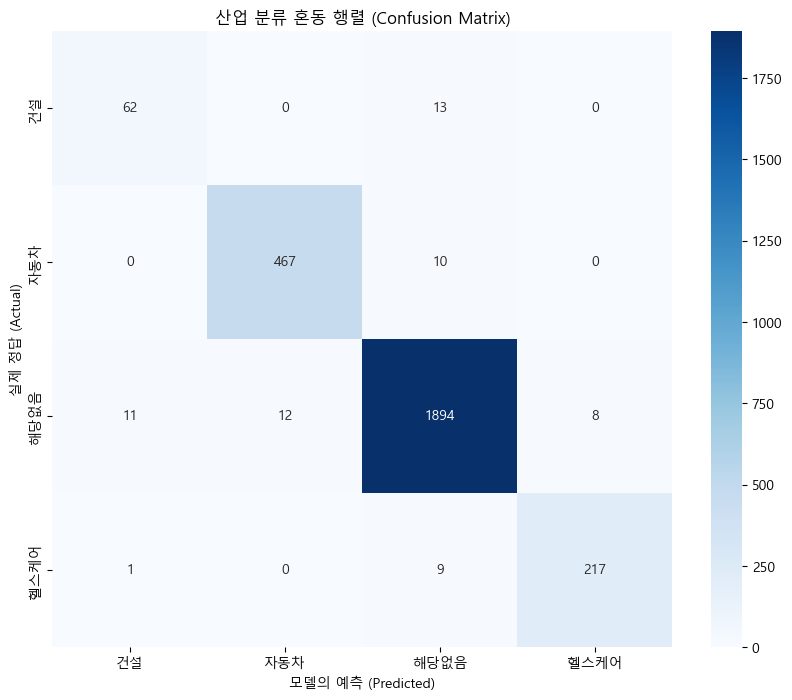

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 한글 폰트 설정 (차트에서 한글이 깨지지 않도록 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False

def plot_classification_results(df, true_col='산업', pred_col='AI_산업분류'):
    # '미분류'라고 나온 데이터는 평가를 위해 제외하거나 별도 처리해야 합니다.
    # 여기서는 모델이 예측한 값들만 추려서 비교합니다.
    eval_df = df[~df[pred_col].str.contains("미분류")].copy()
    
    true_labels = eval_df[true_col]
    pred_labels = eval_df[pred_col]
    
    # 1. 수치형 리포트 출력 (Precision, Recall, F1-score 포함)
    print("### 분류 성능 리포트 ###")
    print(classification_report(true_labels, pred_labels))
    
    # 2. Confusion Matrix (혼동 행렬) 생성
    cm = confusion_matrix(true_labels, pred_labels, labels=le_classes)
    
    # 3. 시각화 (Heatmap)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_classes, 
                yticklabels=le_classes)
    
    plt.title('산업 분류 혼동 행렬 (Confusion Matrix)')
    plt.xlabel('모델의 예측 (Predicted)')
    plt.ylabel('실제 정답 (Actual)')
    plt.show()

# 함수 실행
plot_classification_results(df)

In [67]:
# 실제로는 건설이 아닌데, 모델이 건설이라고 예측한 기사들만 뽑기
wrong_construction = df[(df['산업'] != '건설') & (df['AI_산업분류'] == '건설')]
print(wrong_construction[['title', '산업', 'AI_확신도']].head(10))

                                     title    산업    AI_확신도
642     국내 첫 공공형 반도체 교육기관 '한국반도체교육원' 건립 순항  헬스케어  0.837265
899           '국가 인증 감리제' 첫 우수건설기술인 75명 선정  해당없음  0.857868
950   GS건설, 성북1구역 재개발 수주…올해 도시정비 수주액 6.3조원  해당없음  0.849490
1030      자이S&D, 2천억원 규모 대구 감삼동 공동주택 사업 수주  해당없음  0.807809
1091         금호건설, 평택∼시흥고속도로 확장 민투사업 우협 선정  해당없음  0.853902
1199    검찰, 부산 '공사장 벽돌 사망사고' 원청대표 징역 2년 구형  해당없음  0.832179
1235      평택∼시흥 민자고속도 확장 사업 우협대상자에 키움 컨소시엄  해당없음  0.809109
1247       반도건설, 위례지구 복합용지 낙찰받아…위례신도시 첫 입성  해당없음  0.844773
1297     삼성물산, 4천700억원 규모 호주 송전 설비 프로젝트 수주  해당없음  0.851677
1330           모듈러 특별법 제정 본격 추진…오늘 국회서 공청회  해당없음  0.842465
